In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from importlib import reload 

In [3]:
from deeprank.dataset import DataLoader, PairGenerator, ListGenerator
from deeprank import utils

In [4]:
seed = 1234
torch.manual_seed(seed)

In [5]:
loader = DataLoader('./config/letor07_mp_fold1.model')

[./data/letor/r5w/word_dict.txt]
	Word dict size: 193367
[./data/letor/r5w/qid_query.txt]
	Data size: 1692
[./data/letor/r5w/docid_doc.txt]
	Data size: 65323
[./data/letor/r5w/embed_wiki-pdc_d50_norm]
	Embedding size: 109282
[./data/letor/r5w/embed.idf]
	Embedding size: 193367
Generate numpy embed: (193368, 50)
Generate numpy embed: (193368, 1)


In [6]:
import json
letor_config = json.loads(open('./config/letor07_mp_fold1.model').read())
#device = torch.device("cuda")
#device = torch.device("cpu")
select_device = torch.device("cpu")
rank_device = torch.device("cuda")

In [7]:
Letor07Path = letor_config['data_dir']

letor_config['fill_word'] = loader._PAD_
letor_config['embedding'] = loader.embedding
letor_config['feat_size'] = loader.feat_size
letor_config['vocab_size'] = loader.embedding.shape[0]
letor_config['embed_dim'] = loader.embedding.shape[1]
letor_config['pad_value'] = loader._PAD_

pair_gen = PairGenerator(rel_file=Letor07Path + '/relation.train.fold%d.txt'%(letor_config['fold']), 
                         config=letor_config)

[./data/letor/r5w/relation.train.fold1.txt]
	Instance size: 47828
Pair Instance Count: 325439


In [8]:
from deeprank import select_module
from deeprank import rank_module

In [9]:
'''
letor_config['max_match'] = 20
letor_config['win_size'] = 5
select_net = select_module.QueryCentricNet(config=letor_config, out_device=rank_device)
select_net = select_net.to(select_device)
select_net.train()
'''

"\nletor_config['max_match'] = 20\nletor_config['win_size'] = 5\nselect_net = select_module.QueryCentricNet(config=letor_config, out_device=rank_device)\nselect_net = select_net.to(select_device)\nselect_net.train()\n"

In [10]:
letor_config['q_limit'] = 20
letor_config['d_limit'] = 2000

letor_config['max_match'] = 5
letor_config['win_size'] = 5

letor_config['q_rep_dim'] = 10
letor_config['d_rep_dim'] = 10
letor_config['q_rep_kernel'] = 3
letor_config['d_rep_kernel'] = letor_config['win_size']*2+1

letor_config['finetune_embed'] = False
letor_config['lr'] = 0.0001
select_net = select_module.GroupPointerNet(config=letor_config, out_device=rank_device)
select_net = select_net.to(select_device)
select_net.embedding.weight.data.copy_(torch.from_numpy(loader.embedding))
select_net.train()
select_optimizer = optim.RMSprop(select_net.parameters(), lr=letor_config['lr'])

In [11]:
letor_config["dim_q"] = 1
letor_config["dim_d"] = 1
letor_config["dim_weight"] = 1
letor_config["c_reduce"] = [1, 1]
letor_config["k_reduce"] = [1, 50]
letor_config["s_reduce"] = 1
letor_config["p_reduce"] = [0, 0]

letor_config["c_en_conv_out"] = 4
letor_config["k_en_conv"] = 3
letor_config["s_en_conv"] = 1
letor_config["p_en_conv"] = 1

letor_config["en_pool_out"] = [1, 1]
letor_config["en_leaky"] = 0.2

letor_config["dim_gru_hidden"] = 3

letor_config['lr'] = 0.005
letor_config['finetune_embed'] = False

rank_net = rank_module.DeepRankNet(config=letor_config)
rank_net = rank_net.to(rank_device)
rank_net.embedding.weight.data.copy_(torch.from_numpy(loader.embedding))
rank_net.qw_embedding.weight.data.copy_(torch.from_numpy(loader.idf_embedding))
rank_net.train()
rank_optimizer = optim.Adam(rank_net.parameters(), lr=letor_config['lr'])

In [12]:
def to_device(*variables, device):
    return (torch.from_numpy(variable).to(device) for variable in variables)

In [13]:
def to_device_raw(*variables, device):
    return (variable.to(device) for variable in variables)

In [14]:
def show_text(x):
    print(' '.join([loader.word_dict[w.item()] for w in x]))

In [15]:
X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)

show_text(X2[0])

X1, X2_new, X1_len, X2_len_new, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)

show_text(X1[0])
for i in range(5):
    print(i, end=' ')
    show_text(X2_new[0][i])

bipolar disorder children adolescent search omhsa dpw links dpw home dpw service apply service online home community base service form publication county assistance offices search dpw dpw site map contact dpw omhsa service behavior health choice advisory committee child adolescent service system program cassp cassp publication cassp training institute best practice cross system community support program csp community hospital integrate plan county mental health system drug alcohol county offices seclusion restraint request proposal organization bureau state hospital omhsa state formulary omh bulletin omhsa publication contact omhsa bipolar disorder children adolescent harriet editor edition newsletter different most previous usually theme programmatic transition service partner family mental health juvenile justice collaboration school mental health cultural competence natural support community resources rarely newsletter focus specific mental health disorder relate provision program s

bipolar disease in adolescent $$ [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0 omhsa bipolar disorder children adolescent harriet editor edition newsletter different most
1 topic june kid stigma deadline april september relationship physical mental health
2 attention discover effective intervention treatment medication different therapeutic method add human
3 omhsa dpw links dpw home dpw service apply service online home
4 [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [16]:
X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)

show_text(X2[0])

X1, X2_new, X1_len, X2_len_new, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)

show_text(X1[0])
for i in range(5):
    print(i, end=' ')
    show_text(X2_new[0][i])

department state application passport mail please detach retain instruction sheet record date application use form complete checklist determine eligible use form submit most recent passport least years old most recent passport issue issue most recent passport years ago use name most recent passport name change marriage court order submit proper documentation reflect name change yes yes yes yes answer four statement stop use form apply application form ds making personal appearance passport agent postal clerk clerk court authorize accept passport application careful follow instruction reverse page incomplete unacceptable application delay issue passport please visit website travel state gov contact national passport information center tdd credit card user tdd information question inquiry ds page send application form most recent passport marriage certificate court order name change passport process fee two recent identical photograph light plain background taken month detailed informati

passport information application $$ [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0 face taken light white white background photograph color black white image
1 statement submit headcovere worn daily religious medical reason dark glasses worn
2 home telephone business telephone note most recent passport enclose passport number
3 issue pursuant executive order august part title code federal regulation cfr
4 statement stop use form apply application form ds making personal appearance


In [17]:
print(X2_pos[0].shape)
print(len(X2_pos))
print(len(X2))
print(X2_pos[0])
print(X2_pos[1])

torch.Size([20])
200
200
tensor([ 63.,  68., 106., 178.,  12., 130.,  15.,  97.,  99.,  78.,  15.,  97.,
        161., 201.,  21., 163.,  97.,  41., 175.,  45.], device='cuda:0')
tensor([ 19.,  20., 143., 144., 397.,  14.,  13.,   7.,  17.,   5.,  18.,  19.,
         17.,  14.,  20.,   5.,  19.,  20., 143., 145.], device='cuda:0')


In [18]:
# X1 = X1[:1]
# X1_len = X1_len[:1]
# X2 = X2[:1]
# X2_len = X2_len[:1]
# X1_id = X1_id[:1]
# X2_id = X2_id[:1]

In [19]:
# show_text(X2[0])
# X1, X2_new, X1_len, X2_len_new = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)
# show_text(X1[0])
# for i in range(5):
#     print(i, end=' ')
#     show_text(X2_new[0][i])

In [20]:
print(X2_pos[i][:,None].shape)
print(X2[i].shape)

torch.Size([35, 1])
torch.Size([2000])


In [21]:
import time

rank_loss_list = []
select_loss_list = []

start_t = time.time()
for i in range(200):
    # One Step Forward
    X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
    X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)
    X1, X2, X1_len, X2_len, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)
    X2, X2_len = utils.data_adaptor(X2, X2_len, select_net, rank_net, letor_config)
    output = rank_net(X1, X2, X1_len, X2_len, X2_pos)
    reward = rank_net.pair_reward(output, mode=0)
    
    # Update Rank Net
    rank_loss = rank_net.pair_loss(output, Y)
    print('rank loss:', rank_loss.item())
    rank_loss_list.append(rank_loss.item())
    if i % 1 == 0:
        rank_optimizer.zero_grad()
        rank_loss.backward()
        rank_optimizer.step()
    
    # Update Select Net
    select_loss = select_net.loss(reward)
    print('select loss:', select_loss.item())
    select_loss_list.append(select_loss.item())
    select_optimizer.zero_grad()
    select_loss.backward()
    select_optimizer.step()
    
end_t = time.time()
print('Time Cost: %s s' % (end_t-start_t))

rank loss: 0.8759759068489075
select loss: -50.06583023071289
rank loss: 0.9484403729438782
select loss: -42.33018493652344
rank loss: 0.9103724360466003
select loss: -45.94489288330078
rank loss: 0.8995844125747681
select loss: -25.045923233032227
rank loss: 0.8307730555534363
select loss: -80.60164642333984
rank loss: 0.8919680118560791
select loss: -16.089332580566406
rank loss: 0.849761962890625
select loss: -81.79977416992188
rank loss: 0.9520921111106873
select loss: -37.109676361083984
rank loss: 0.8020379543304443
select loss: -99.7043685913086
rank loss: 0.9987389445304871
select loss: -2.445683240890503
rank loss: 0.8682011365890503
select loss: -83.61199188232422
rank loss: 0.9173089265823364
select loss: -101.56730651855469
rank loss: 1.0194984674453735
select loss: -15.641357421875
rank loss: 0.810495138168335
select loss: -53.74839401245117
rank loss: 0.8618379235267639
select loss: -65.1640853881836
rank loss: 0.9968340992927551
select loss: -15.597787857055664
rank loss

select loss: -78.97579956054688
rank loss: 1.003970980644226
select loss: -65.17428588867188
rank loss: 0.9001356363296509
select loss: -38.26739501953125
rank loss: 0.7411861419677734
select loss: -109.34696960449219
rank loss: 0.7464630007743835
select loss: -80.0713119506836
rank loss: 0.756953775882721
select loss: -93.17547607421875
rank loss: 0.851022481918335
select loss: -63.379817962646484
rank loss: 0.7509588599205017
select loss: -52.627601623535156
rank loss: 0.7904291152954102
select loss: -100.92131042480469
rank loss: 0.830808699131012
select loss: -74.06494903564453
rank loss: 0.831898033618927
select loss: -62.76027297973633
rank loss: 0.9343308806419373
select loss: -32.875247955322266
rank loss: 0.8484179377555847
select loss: -57.99215316772461
rank loss: 0.8476517200469971
select loss: -86.10028076171875
rank loss: 0.8435848951339722
select loss: -75.20043182373047
rank loss: 0.6961243748664856
select loss: -151.12979125976562
rank loss: 0.8582682013511658
select l

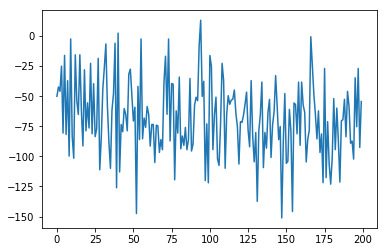

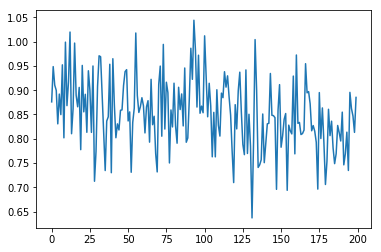

In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure()
plt.plot(select_loss_list)
plt.show()

plt.figure()
plt.plot(rank_loss_list)
plt.show()

In [23]:
torch.save(select_net, "qcentric.model")
torch.save(rank_net, "deeprank.model")

In [24]:
select_net_e = torch.load(f='qcentric.model')
rank_net_e = torch.load(f='deeprank.model')

list_gen = ListGenerator(rel_file=Letor07Path+'/relation.test.fold%d.txt'%(letor_config['fold']),
                         config=letor_config)
map_v = 0.0
map_c = 0.0

with torch.no_grad():
    for X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F in \
        list_gen.get_batch(data1=loader.query_data, data2=loader.doc_data):
        #print(X1.shape, X2.shape, Y.shape)
        X1, X1_len, X2, X2_len, Y, F = to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)
        X1, X2, X1_len, X2_len, X2_pos = select_net_e(X1, X2, X1_len, X2_len, X1_id, X2_id)
        X2, X2_len = utils.data_adaptor(X2, X2_len, select_net, rank_net, letor_config)
        #print(X1.shape, X2.shape, Y.shape)
        pred = rank_net_e(X1, X2, X1_len, X2_len, X2_pos)
        map_o = utils.eval_MAP(pred.tolist(), Y.tolist())
        #print(pred.shape, Y.shape)
        map_v += map_o
        map_c += 1.0
    map_v /= map_c

print('[Test]', map_v)

[./data/letor/r5w/relation.test.fold1.txt]
	Instance size: 13652
List Instance Count: 336
[Test] 0.4083692824951091
